### Neural Net LSTM Model Supervised Learning step by step

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential
from datetime import datetime

### Step 1: Load the Data

In [11]:
folder = os.getcwd()

dataPath = os.path.dirname(folder) + '\\data\\Industrials\\Boeing'
frames = []
for _,_,files in os.walk(dataPath):
    for file in files:
        # print(dataPath + '\\' + file)
        data = dataPath + '\\' + file
        data = pd.read_csv(data)
        data = data.set_index('Dates')
        data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
        data.sort_index(inplace = True)
        frames.append(data)


# frames = [data_df, sentData, rsi10, sma10]
data_df = pd.concat(frames,axis =1)
data_df = data_df.dropna()
data_df.sort_index(inplace=True)

### Step 2: Split the Data into training and validation sets

In [43]:
X = data_df[['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close', 'Total Sentiment', 'Number of Articles', 'RSI Values','SMA Values']]
X = X.iloc[:-21]
y_1_week = data_df['Close'].iloc[7:-14]
y_2_weeks = data_df['Close'].iloc[14:-7]
y_3_weeks = data_df['Close'].iloc[21:]

y = pd.DataFrame({'Close_1_Week': y_1_week.values, 'Close_2_Weeks': y_2_weeks.values, 'Close_3_Weeks': y_3_weeks.values}, index=None)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = False)

### Step 3: Normalize Data

In [44]:
scaler = MinMaxScaler()
X_trainScaled = scaler.fit_transform(X_train)
X_valScaled = scaler.fit_transform(X_val)
y_trainScaled = scaler.fit_transform(y_train)
y_valScaled = scaler.fit_transform(y_val)


### Step 4: Create and Train the Model

In [45]:
X_trainScaled = X_trainScaled.reshape(X_trainScaled.shape[0],X_trainScaled.shape[1],1)
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_trainScaled.shape[1], X_trainScaled.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dense(3))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_trainScaled.reshape(X_trainScaled.shape[0], X_trainScaled.shape[1], 1), y_trainScaled, 
          epochs=100, batch_size=32, validation_data=(X_valScaled.reshape(X_valScaled.shape[0], X_valScaled.shape[1], 1), y_valScaled))

Epoch 1/100
124/124 [==============================] - 3s 10ms/step - loss: 0.0246 - val_loss: 0.0065
Epoch 2/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0061
Epoch 3/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 4/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0069
Epoch 5/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 6/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0060
Epoch 7/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 8/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 9/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0059
Epoch 10/100
124/124 [==============================] - 1s 8ms/step - loss: 0.0014 - val_l

### Step 5: Predict using the Trained Model

In [46]:
y_pred_scaled = model.predict(X_valScaled.reshape(X_valScaled.shape[0], X_valScaled.shape[1], 1))
y_pred = scaler.inverse_transform(y_pred_scaled)
y_val1 = y_val['Close_1_Week'].tolist()
X_close = X_val['Close'].tolist()
buyReal=False
buyReal_dic={'buy':[],'sell':[]}
buyTrain = False
buyTrain_dic = {'buy':[],'sell':[]}
for i in range(0,len(X_close)):
    # print(y_1_week_train_actual[i],X_close_actual[i])
    if y_val1[i] > X_close[i]:
        if buyReal == True:
            pass
        else:
            buyReal = True
            buyReal_dic['buy'].append(X_close[i])
    if y_val1[i] < X_close[i]:
        if buyReal == False:
            pass
        else:
            buyReal = False
            buyReal_dic['sell'].append(X_close[i])


    if y_pred[i,0] > X_close[i]:
        if buyTrain == True:
            pass
        else:
            buyTrain = True
            buyTrain_dic['buy'].append(X_close[i])
    if y_pred[i,0] < X_close[i]:
        if buyTrain == False:
            pass
        else:
            buyTrain = False
            buyTrain_dic['sell'].append(X_close[i])

print(len(buyTrain_dic['sell']),len(buyTrain_dic['buy']))
trainGain = 100
for i in range(0,len(buyTrain_dic['sell'])):
    trainGain = (1+(buyTrain_dic['buy'][i]-buyTrain_dic['sell'][i])/buyTrain_dic['buy'][i])*trainGain

53/53 [==============================] - 0s 3ms/step
161 162


### Step 6: Plotting

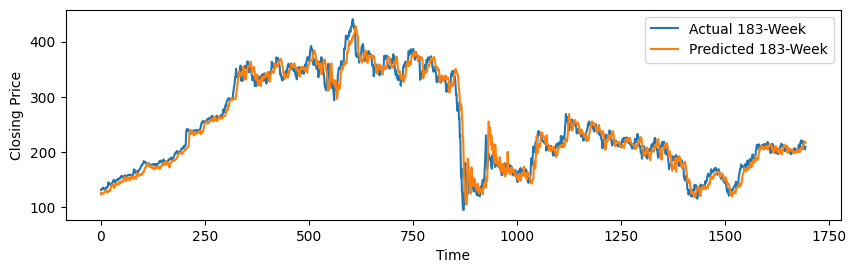

In [12]:
# for i in range(3):
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(y_val1, label=f'Actual {i+1}-Week')
plt.plot(y_pred[:, 0], label=f'Predicted {i+1}-Week')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
    # plt.title(f'Closing Price Prediction {i+1}-Weeks Ahead')
    # plt.subplot(2,1,2)
    # plt.plot( X_close_cur[-length_:].index, y_val_actual[:, i] - y_pred[:, i] )
plt.show()